# mlreflect usage example

In [1]:
%load_ext autoreload

In [46]:
import matplotlib.pyplot as plt
import numpy as np

import mlreflect

from mlreflect import ReflectivityGenerator, InputPreprocessor, OutputPreprocessor, Prediction
from mlreflect import h5_tools
from mlreflect.models.simple_model import SimpleModel
from mlreflect.models.model_helpers import create_save_directory

print('Tested with version: ' + mlreflect.__version__)

Tested with version: 0.11.0


### Load experimental data
In this case DIP_303K.txt contains columns of reflectivity data with the first column containing the q-values in units 1/A

In [3]:
experiment = np.loadtxt('DIP_303K.txt')

In [4]:
q = experiment[9:, 0] # Extract q-values
experimental_reflectivity = experiment[9:, 1:].T

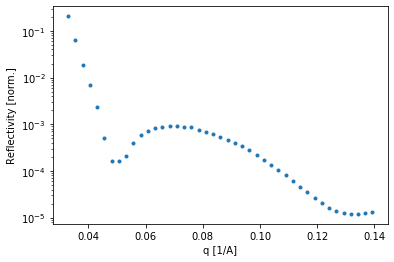

In [5]:
plt.semilogy(q, experimental_reflectivity[30, :], '.')
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Generate random training data
Choose parameter ranges for the randomly generated training data with mininimum and maximum values for each layer in descending order (the substrate last).

In [6]:
thickness_ranges = [(20.0, 300.0), (2.8, 30), (100.0, 100.0)] # in units A
roughness_ranges = [(0.0, 60.0), (2.5, 2.5), (1.0, 1.0)] # in units A
sld_ranges = [(1.0, 14.0), (17.8, 17.8), (20.1, 20.1)] # in units 1/A^2 * 10^-6

In [7]:
rg = ReflectivityGenerator(q, 0) # Initialize ReflectivityGenerator object with ambient SLD of 0 (air for X-ray)
random_labels = rg.generate_random_labels(thickness_ranges, roughness_ranges, sld_ranges, 225000)

Finished 'generate_random_labels' in 1.9674 secs


In [8]:
random_labels[0:4] # Quick inspection if the generated parameters are as expected

,layer3_thickness,layer2_thickness,layer1_thickness,layer3_roughness,layer2_roughness,layer1_roughness,layer3_sld,layer2_sld,layer1_sld
0,42.236494,17.885805,100.0,11.365871,2.5,1.0,11.536541,17.8,20.1
1,276.695519,9.861399,100.0,51.311611,2.5,1.0,1.727505,17.8,20.1
2,130.523685,16.488524,100.0,51.984283,2.5,1.0,2.356929,17.8,20.1
3,123.747536,3.853654,100.0,10.280674,2.5,1.0,10.851176,17.8,20.1


In [9]:
random_reflectivity = rg.simulate_reflectivity(random_labels) # Simulate reflectivity using the generated parameters

100%|██████████| 225000/225000 [02:55<00:00, 1283.50it/s]

Finished 'simulate_reflectivity' in 175.6270 secs


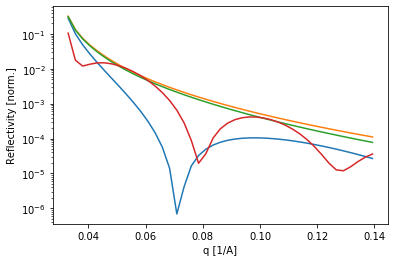

In [10]:
plt.semilogy(q, random_reflectivity[0, :])
plt.semilogy(q, random_reflectivity[1, :])
plt.semilogy(q, random_reflectivity[2, :])
plt.semilogy(q, random_reflectivity[3, :])
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

In [11]:
sld_profiles = rg.simulate_sld_profiles(random_labels) # Simulate SLD profile for visual inspection

100%|██████████| 225000/225000 [01:11<00:00, 3130.55it/s]

Finished 'simulate_sld_profiles' in 71.8876 secs


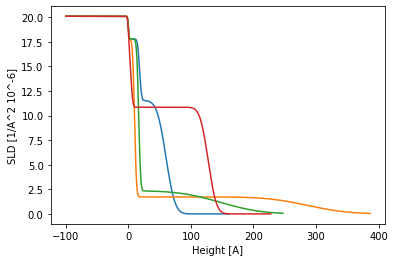

In [12]:
plt.plot(sld_profiles[0][0, :], sld_profiles[0][1, :])
plt.plot(sld_profiles[1][0, :], sld_profiles[1][1, :])
plt.plot(sld_profiles[2][0, :], sld_profiles[2][1, :])
plt.plot(sld_profiles[3][0, :], sld_profiles[3][1, :])
plt.xlabel('Height [A]')
plt.ylabel('SLD [1/A^2 10^-6]')
plt.show()

Split labels and reflectivity into training, validation and testing sets. Since labels are saved as a pandas DataFrame, the index must be dropped.

In [13]:
train_labels = random_labels[:200000].reset_index(drop=True)
val_labels = random_labels[200000:220000].reset_index(drop=True)
test_labels = random_labels[220000:].reset_index(drop=True)

In [14]:
train_reflectivity = random_reflectivity[:200000, :]
val_reflectivity = random_reflectivity[200000:220000, :]
test_reflectivity = random_reflectivity[220000:, :]

Write data to an h5 file so it can be reused later.

In [15]:
create_save_directory('output/')
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'train', q, train_reflectivity, train_labels)
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'val', q, val_reflectivity, val_labels)
h5_tools.save_data_as_h5('output/saved_training_data.h5', 'test', q, test_reflectivity, test_labels)

In [16]:
# loaded_data = h5_tools.read_from_h5('saved_training_data.h5', 'train') # Data can be loaded like this

### Train neural network

Initialize InputPreprocessor object and add jobs to the preprocessing list.

In [17]:
ip = InputPreprocessor()

ip.append_to_job_list(ip.log)
ip.append_to_job_list(ip.standardize)

Apply preprocessing to the input data.

In [18]:
train_reflectivity_pp = ip.apply_preprocessing(train_reflectivity)
val_reflectivity_pp = ip.apply_preprocessing(val_reflectivity)
test_reflectivity_pp = ip.apply_preprocessing(test_reflectivity)

Initialize OutputPreprocessor object with the used label ranges and apply preprocessing to the labels.

In [19]:
op = OutputPreprocessor(thickness_ranges, roughness_ranges, sld_ranges)

train_labels_pp = op.apply_preprocessing(train_labels)
val_labels_pp = op.apply_preprocessing(val_labels)
test_labels_pp = op.apply_preprocessing(test_labels)

Train the neural network using the model defined in SimpleModel and save results in 'output/simple_model/'.

In [20]:
simple_model = SimpleModel('output/simple_model/', train_reflectivity_pp.shape[1], train_labels_pp.shape[1])
hist = simple_model.train(train_reflectivity_pp, train_labels_pp, val_reflectivity_pp, val_labels_pp)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               17600     
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 800)               320800    
_________________________________________________________________
activation_2 (Activation)    (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               320400    
_________________________________________________________________
activation_3 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               120300    
_______

200000/200000 [==============================] - 4s 19us/step - loss: 0.0020 - val_loss: 0.0025

Epoch 00024: val_loss did not improve from 0.00155
Epoch 25/60
200000/200000 [==============================] - 4s 20us/step - loss: 0.0021 - val_loss: 0.0018

Epoch 00025: val_loss did not improve from 0.00155
Epoch 26/60
200000/200000 [==============================] - 3s 17us/step - loss: 0.0019 - val_loss: 0.0016

Epoch 00026: val_loss did not improve from 0.00155
Epoch 27/60
200000/200000 [==============================] - 4s 18us/step - loss: 0.0020 - val_loss: 0.0016

Epoch 00027: val_loss did not improve from 0.00155
Epoch 28/60
200000/200000 [==============================] - 3s 14us/step - loss: 0.0019 - val_loss: 0.0015

Epoch 00028: val_loss improved from 0.00155 to 0.00152, saving model to output/simple_model/models/2020-01-16-184630.h5
Epoch 29/60
200000/200000 [==============================] - 4s 19us/step - loss: 0.0019 - val_loss: 0.0016

Epoch 00029: val_loss did not impr

Inspect training and validation loss.

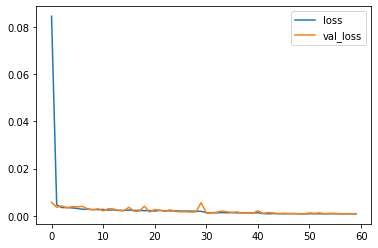

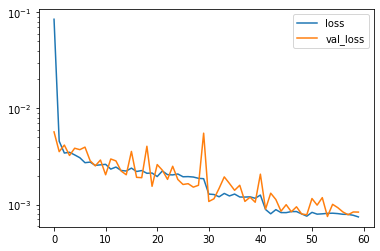

In [21]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.semilogy(hist.history['loss'], label='loss')
plt.semilogy(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Test on simulated data

Initialize the Prediction object for the given model and labels.

In [22]:
timestamp = '2020-01-16-184630' # Timestamp needs to be adjusted to the one of the trained model
pr = Prediction('output/simple_model/models/' + timestamp + '.h5', op.used_label_names)

In [23]:
pred_test_labels = pr.predict_labels(test_reflectivity_pp) # Predict labels for simulated test data

Finished 'predict_labels' in 0.2078 secs


In [24]:
test_labels_pp # Inspect previously generated and preprocessed test labels

,layer3_thickness,layer2_thickness,layer3_roughness,layer3_sld
0,0.036143,0.960918,0.239258,0.014389
1,0.890387,0.678420,0.892867,0.194181
2,0.560571,0.517828,0.921494,0.347244
3,0.872089,0.227100,0.823450,0.921405
4,0.724488,0.849462,0.290918,0.272867
...,...,...,...,...
4995,0.461156,0.138857,0.742163,0.711351
4996,0.342588,0.911551,0.165002,0.324532
4997,0.925905,0.565407,0.003747,0.479503
4998,0.995561,0.367523,0.086612,0.049352


In [25]:
pred_test_labels # Inspect predicted test labels

,layer3_thickness,layer2_thickness,layer3_roughness,layer3_sld
0,0.043043,0.922291,0.154322,0.003834
1,0.895771,0.684641,0.898459,0.199704
2,0.564669,0.514683,0.932708,0.351214
3,0.871919,0.221446,0.823764,0.924515
4,0.720378,0.849072,0.288359,0.273701
...,...,...,...,...
4995,0.462465,0.142933,0.741863,0.714137
4996,0.334740,0.896851,0.157527,0.310599
4997,0.923050,0.563348,0.014506,0.477163
4998,0.995915,0.363155,0.095723,0.052008


In [26]:
pred_test_labels.reset_index(drop=True) - test_labels_pp.reset_index(drop=True) # Calculate absolute error

,layer3_thickness,layer2_thickness,layer3_roughness,layer3_sld
0,0.006900,-0.038627,-0.084936,-0.010555
1,0.005384,0.006221,0.005592,0.005523
2,0.004097,-0.003145,0.011213,0.003970
3,-0.000170,-0.005654,0.000314,0.003110
4,-0.004110,-0.000390,-0.002559,0.000834
...,...,...,...,...
4995,0.001308,0.004076,-0.000300,0.002786
4996,-0.007849,-0.014701,-0.007475,-0.013933
4997,-0.002855,-0.002060,0.010759,-0.002340
4998,0.000354,-0.004368,0.009111,0.002656


In [27]:
mae = pr.mean_absolute_error(pred_test_labels, test_labels_pp) # Calculate mean absolute error
print(mae)

layer3_thickness    0.004347
layer2_thickness    0.017437
layer3_roughness    0.008447
layer3_sld          0.011278
dtype: float64


In [28]:
mape = pr.mean_absolute_percentage_error(pred_test_labels, test_labels_pp) # Calculate mean absolute percentage error
print(mape)

layer3_thickness    0.126306
layer2_thickness    0.342645
layer3_roughness    0.244443
layer3_sld          0.055138
dtype: float64


In [29]:
test_labels # Inspect previously generated test labels

,layer3_thickness,layer2_thickness,layer1_thickness,layer3_roughness,layer2_roughness,layer1_roughness,layer3_sld,layer2_sld,layer1_sld
0,30.120015,28.936978,100.0,14.355495,2.5,1.0,1.187060,17.8,20.1
1,269.308324,21.253023,100.0,53.572019,2.5,1.0,3.524348,17.8,20.1
2,176.959971,16.884910,100.0,55.289652,2.5,1.0,5.514172,17.8,20.1
3,264.184948,8.977132,100.0,49.407024,2.5,1.0,12.978266,17.8,20.1
4,222.856594,25.905358,100.0,17.455100,2.5,1.0,4.547269,17.8,20.1
...,...,...,...,...,...,...,...,...,...
4995,149.123789,6.576914,100.0,44.529784,2.5,1.0,10.247563,17.8,20.1
4996,115.924712,27.594197,100.0,9.900132,2.5,1.0,5.218914,17.8,20.1
4997,279.253303,18.179080,100.0,0.224812,2.5,1.0,7.233542,17.8,20.1
4998,298.757001,12.796638,100.0,5.196719,2.5,1.0,1.641577,17.8,20.1


In [30]:
restored_pred_test_labels = op.restore_labels(pred_test_labels, test_labels) # Reverse preprocessing on predicted test labels

In [31]:
restored_pred_test_labels # Inspect predicted test labels without preprocessing

,layer3_thickness,layer2_thickness,layer1_thickness,layer3_roughness,layer2_roughness,layer1_roughness,layer3_sld,layer2_sld,layer1_sld
0,32.051926,27.886312,100.0,9.259327,2.5,1.0,1.049847,17.8,20.1
1,270.815796,21.422241,100.0,53.907547,2.5,1.0,3.596147,17.8,20.1
2,178.107224,16.799368,100.0,55.962452,2.5,1.0,5.565776,17.8,20.1
3,264.137207,8.823338,100.0,49.425835,2.5,1.0,13.018702,17.8,20.1
4,221.705902,25.894760,100.0,17.301542,2.5,1.0,4.558117,17.8,20.1
...,...,...,...,...,...,...,...,...,...
4995,149.490128,6.687785,100.0,44.511780,2.5,1.0,10.283779,17.8,20.1
4996,113.727119,27.194336,100.0,9.451609,2.5,1.0,5.037791,17.8,20.1
4997,278.453888,18.123060,100.0,0.870378,2.5,1.0,7.203117,17.8,20.1
4998,298.856262,12.677820,100.0,5.743399,2.5,1.0,1.676102,17.8,20.1


Compare test labels with predicted test labels.

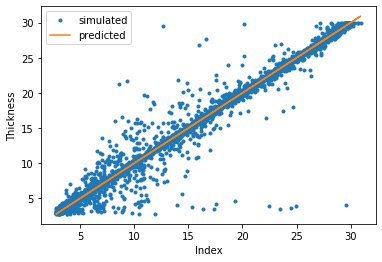

In [32]:
plt.plot(restored_pred_test_labels['layer2_thickness'], test_labels['layer2_thickness'], '.', label='simulated')
plt.plot(restored_pred_test_labels['layer2_thickness'], restored_pred_test_labels['layer2_thickness'], label='predicted')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Thickness')
plt.show()

Simulate reflectivity from predicted labels.

In [33]:
pred_test_reflectivity = rg.simulate_reflectivity(restored_pred_test_labels)

100%|██████████| 5000/5000 [00:04<00:00, 1223.64it/s]

Finished 'simulate_reflectivity' in 4.1104 secs


Plot test reflectivity with predicted reflectivity

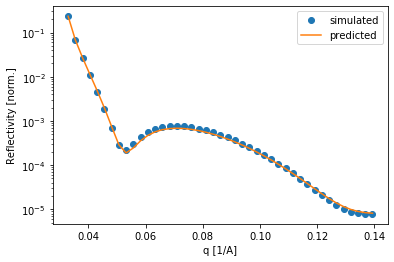

In [37]:
plt.semilogy(q, test_reflectivity[600, :], 'o', label='simulated')
plt.semilogy(q, pred_test_reflectivity[600, :], label='predicted')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()

### Test on experimental data

In [38]:
experimental_reflectivity_pp = ip.apply_preprocessing(experimental_reflectivity)

In [39]:
pred_experimental_test_labels = pr.predict_labels(experimental_reflectivity_pp) # Predict labels for experimental test data

Finished 'predict_labels' in 0.0195 secs


In [40]:
pred_experimental_test_labels

,layer3_thickness,layer2_thickness,layer3_roughness,layer3_sld
0,0.541733,0.530119,0.193355,0.000000
1,0.287133,0.553734,0.156139,0.057596
2,0.030733,0.592410,0.143392,0.100092
3,0.148798,0.673932,0.228939,0.110132
4,0.008264,0.698568,0.133066,0.278345
...,...,...,...,...
64,0.459720,0.183439,0.473456,0.813249
65,0.467796,0.206978,0.480113,0.814792
66,0.474382,0.168202,0.491040,0.835723
67,0.491130,0.141524,0.496664,0.849179


In [41]:
restored_pred_experimental_test_labels = op.restore_labels(pred_experimental_test_labels, test_labels) # Reverse preprocessing on predicted test labels

In [42]:
restored_pred_experimental_test_labels

,layer3_thickness,layer2_thickness,layer1_thickness,layer3_roughness,layer2_roughness,layer1_roughness,layer3_sld,layer2_sld,layer1_sld
0,171.685135,17.219234,100.0,11.601306,2.5,1.0,1.000000,17.8,20.1
1,100.397293,17.861565,100.0,9.368336,2.5,1.0,1.748743,17.8,20.1
2,28.605156,18.913565,100.0,8.603546,2.5,1.0,2.301202,17.8,20.1
3,61.663486,21.130939,100.0,13.736342,2.5,1.0,2.431716,17.8,20.1
4,22.313808,21.801056,100.0,7.983932,2.5,1.0,4.618488,17.8,20.1
...,...,...,...,...,...,...,...,...,...
64,148.721573,7.789530,100.0,28.407341,2.5,1.0,11.572235,17.8,20.1
65,150.982758,8.429810,100.0,28.806755,2.5,1.0,11.592290,17.8,20.1
66,152.826950,7.375099,100.0,29.462395,2.5,1.0,11.864398,17.8,20.1
67,157.516357,6.649462,100.0,29.799849,2.5,1.0,12.039332,17.8,20.1


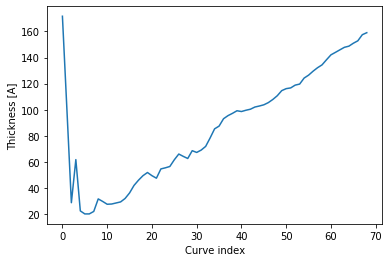

In [43]:
plt.plot(restored_pred_experimental_test_labels['layer3_thickness'])
plt.xlabel('Curve index')
plt.ylabel('Thickness [A]')
plt.show()

In [44]:
pred_experimental_reflectivity = rg.simulate_reflectivity(restored_pred_experimental_test_labels)

100%|██████████| 69/69 [00:00<00:00, 923.23it/s]

Finished 'simulate_reflectivity' in 0.0810 secs


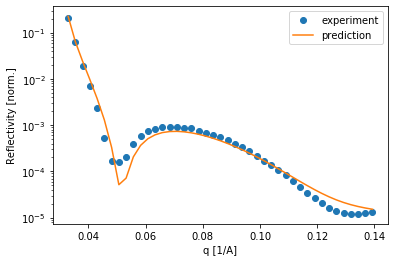

In [45]:
plt.semilogy(q, experimental_reflectivity[30, :], 'o', label='experiment')
plt.semilogy(q, pred_experimental_reflectivity[30, :], label='prediction')
plt.legend()
plt.xlabel('q [1/A]')
plt.ylabel('Reflectivity [norm.]')
plt.show()